In [5]:
import numpy as np
import cv2
from scipy.optimize import lsq_linear
# from jetbot import Robot, Camera, bgr8_to_jpeg
from IPython.display import display, Image, clear_output

def bgr8_to_jpeg(image, quality=90):
    if image is None or not isinstance(image, np.ndarray):
        raise ValueError("Invalid image for JPEG encoding")

    if image.dtype != np.uint8:
        image = np.clip(image, 0, 255).astype(np.uint8)

    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    encode_params = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    success, jpeg = cv2.imencode('.jpg', image, encode_params)
    if not success:
        raise ValueError("JPEG encoding failed")
    return jpeg.tobytes()


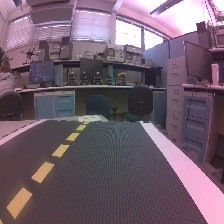

In [6]:
image = cv2.imread('Test_Lane_Images/image_0.jpg')
display(Image(data=bgr8_to_jpeg(image)))

In [55]:
def detect_lane_markings(image: np.ndarray):
    """
    Args:
        image: An image from the robot's camera in the BGR color space (numpy.ndarray)
    Return:
        left_masked_img:   Masked image for the dashed-yellow line (numpy.ndarray)
        right_masked_img:  Masked image for the solid-white line (numpy.ndarray)
    """
    h, w, _ = image.shape
    # print(image.shape)

    imgbgr = image

    # Convert the image to HSV for any color-based filtering
    imghsv = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2HSV)

    # Most of our operations will be performed on the grayscale version
    imggray = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2GRAY)

    horizon_X = 130
    mask_ground = np.zeros((h, w), dtype=np.uint8)
    mask_ground[int(h - horizon_X) :, :] = 1
    # print(h," " ,w," " ,int(h - horizon_X[0]))

    sigma = 8  # CHANGE ME

    # Smooth the image using a Gaussian kernel
    img_gaussian_filter = cv2.GaussianBlur(imggray, (0, 0), sigma)

    # Convolve the image with the Sobel operator (filter) to compute the numerical derivatives in the x and y directions
    sobelx = cv2.Sobel(img_gaussian_filter, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(img_gaussian_filter, cv2.CV_64F, 0, 1)

    # Compute the magnitude of the gradients
    Gmag = np.sqrt(sobelx * sobelx + sobely * sobely)

    threshold_left = 5  # CHANGE ME
    mask_mag_left = Gmag > threshold_left
    threshold_right = 35
    mask_mag_right = Gmag > threshold_right

    white_lower_hsv = np.array([15, 3, 166])  # CHANGE ME
    white_upper_hsv = np.array([179, 116, 255])  # CHANGE ME
    yellow_lower_hsv = np.array([10, 75, 50])        # CHANGE ME
    yellow_upper_hsv = np.array([35, 255, 255])  # CHANGE ME

    mask_white = cv2.inRange(imghsv, white_lower_hsv, white_upper_hsv)
    mask_yellow = cv2.inRange(imghsv, yellow_lower_hsv, yellow_upper_hsv)

    mask_left = np.ones(sobelx.shape)
    mask_left[:, int(np.floor(w / 2)) : w + 1] = 0
    mask_right = np.ones(sobelx.shape)
    mask_right[:, 0 : int(np.floor(w / 2))] = 0

    mask_sobelx_pos = sobelx > 0
    mask_sobelx_neg = sobelx < 0
    mask_sobely_neg = sobely < 0

    mask_left_edge = mask_ground * mask_left * mask_mag_left * mask_sobelx_neg * mask_sobely_neg * mask_yellow
    mask_right_edge = mask_ground * mask_right * mask_mag_right * mask_sobelx_pos * mask_sobely_neg * mask_white
    mask_lanes = np.uint8((mask_left_edge + mask_right_edge) > 0) * 255
    test_image = imggray*mask_mag_left*Gmag
    masked_image = cv2.bitwise_and(image, image, mask=mask_lanes)
    # display(Image(data=bgr8_to_jpeg(test_image)))
    # display(Image(data=bgr8_to_jpeg(image)))

    return masked_image

In [56]:
def fit_hyperbola_pair(masked_img, h, lane_width=80, boundary_thresh=1.5):
    """
    Fit a hyperbola-pair model to masked lane edges.
    
    Args:
        masked_img: Binary or edge-detected image with lane edges.
        h: Horizon height (baseline for v-axis in hyperbola model).
        lane_width: Approx. lane width in pixels.
        boundary_thresh: Tolerance for outlier rejection.
    
    Returns:
        Dictionary with parameters: k, bl, br, bc, c, and the fitted center lane u(v)
    """

    # Step 1: Get non-zero points (edge pixels)
    v, u = np.nonzero(masked_img)
    u = u.astype(np.float32)
    v = v.astype(np.float32)

    # Avoid division by zero near horizon
    # epsilon = 1e-3
    # valid_idx = np.abs(v - h) > epsilon
    # u = u[valid_idx]
    # v = v[valid_idx]

    if len(u) <= 50:
        raise ValueError("Not enough lane edge points found.")

    # Step 2: Split left and right lanes
    center_x = masked_img.shape[1] / 2
    left_idx = u < center_x
    right_idx = u >= center_x

    v_left, u_left = v[left_idx], u[left_idx]
    v_right, u_right = v[right_idx], u[right_idx]
    # print(v_left)

    # Step 3: Build design matrix for least-squares
    def build_matrix(v_arr):
        v_rel = v_arr - h
        A = np.vstack([
            1.0 / v_rel,        # for k
            v_rel,              # for b
            np.ones_like(v_rel) # for c
        ]).T
        return A

    A_left = build_matrix(v_left)
    A_right = build_matrix(v_right)
    b_left = u_left
    b_right = u_right

    # Combine for full problem: [k, bl, br, c]
    A_full = np.vstack([
        np.hstack([A_left[:,0:1], A_left[:,1:2], np.zeros_like(A_left[:,1:2]), A_left[:,2:3]]),
        np.hstack([A_right[:,0:1], np.zeros_like(A_right[:,1:2]), A_right[:,1:2], A_right[:,2:3]])
    ])
    b_full = np.concatenate([b_left, b_right])

    # Ensure correct dtype
    A_full = A_full.astype(np.float64)
    b_full = b_full.astype(np.float64)

    # Bounds (you can tune these based on image dimensions)
    low_b = np.array([-1e6, -10, -10, center_x - 30])
    up_b = np.array([1e6, 10, 10, center_x + 30])

    # Solve least-squares with bounds
    sol = lsq_linear(A_full, b_full, bounds=(low_b, up_b))
    k, bl, br, c = sol.x
    bc = (bl + br) / 2

    # Compute center lane for all vertical points
    v_full = np.arange(masked_img.shape[0])
    u_center = k / (v_full - h + 1e-6) + bc * (v_full - h) + c  # add small epsilon to avoid div by zero

    return {
        "k": k,
        "bl": bl,
        "br": br,
        "bc": bc,
        "c": c,
        "v": v_full,
        "u_center": u_center
    }


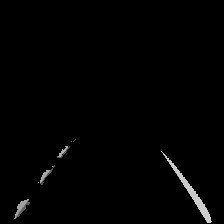

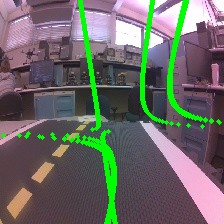

In [57]:
# masked_img: from detect_lane_markings()
masked_image = detect_lane_markings(image)
masked_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
display(Image(data=bgr8_to_jpeg(masked_image)))
params = fit_hyperbola_pair(masked_image, h=130.1)

# To draw the fitted center lane:
for v, u in zip(params['v'], params['u_center']):
    if 0 <= int(u) < masked_image.shape[1]:
        cv2.circle(image, (int(u), int(v)), 2, (0, 255, 0), -1)

display(Image(data=bgr8_to_jpeg(image)))

In [ ]:

"""

 Title: Lane Detection Algorithm
 Author: Anton Elmiger
 Created: 2020-05-26

 Information: Class that extracts a lane from an edge image
              and calculates the corresponding hyperbola-pair parameters

              Lane Model is described in this paper https://ieeexplore.ieee.org/abstract/document/1689679
              and in the wiki of github

"""


import numpy as np
import cv2
from scipy.optimize import lsq_linear
import CP_constants as const
from collections import deque  
      
class Lane_Detection:
    def __init__(self):
        self.v = np.arange(0, const.IMAGE_HEIGHT, 1)  # vertical points
        self.u = np.arange(0, const.IMAGE_WIDTH, 1)  # horizontal points

        self.threshold = const.BOUNDARY_THRESH
        self.lane_width = const.LANE_WIDTH

        self.h = const.HORIZON # h-horizon height
        self.k = 0  # k-curvature of lane
        self.bl = 0 # b-skew of left lane
        self.br = 0 # b-skew of right lane
        self.bc = 0 # b-skew of lane center
        self.c = 0 # c-horizontal offset of lane

        self.bcdq = deque(maxlen=const.FILTER_STRENGTH)   
        self.bldq = deque(maxlen=const.FILTER_STRENGTH)   
        self.brdq = deque(maxlen=const.FILTER_STRENGTH)   

        self.left_lane_points = np.array([])
        self.right_lane_points = np.array([])
        
        self.lane = np.array([])

        # Bounds for the solving of hyperbola-pair parameters
        # [k,bl,br,c]
        # The constraint on c dramatically increases robustness
        self.low_b = np.array([-500000, -8, -8, const.IMAGE_WIDTH/2 -20])
        self.up_b = np.array([500000, 8, 8, const.IMAGE_WIDTH/2 +20])

    # Calculate lane hyperbola for given parameters
    def hyperbola_pair(self, b):
        return self.k/(self.v-self.h)+b*(self.v-self.h)+self.c

    # Function finds lane points in an edge image and classifies them to left and right lane
    # This function is used if no lane estimate exists, or the estimation is odd
    def get_initial_lane_points(self, edge_image):
        image_height = edge_image.shape[0]
        image_width = edge_image.shape[1]

        # initialize lane arrays
        left_lane_points = np.empty((image_height, 1))
        left_lane_points[:] = np.NAN
        right_lane_points = np.empty((image_height, 1))
        right_lane_points[:] = np.NAN

        lane_numbers = np.arange(image_width)
        edge_image = edge_image / 255

        for row in range(image_height-1, -1, -1):
            curr_row = np.multiply(
                (lane_numbers - image_height), edge_image[row, :])
            points_to_the_right = np.where(curr_row > 0)[0]
            points_to_the_left = np.where(curr_row < 0)[0]
            if points_to_the_right.size > 0:
                right_lane_points[row] = np.amin(points_to_the_right)
            if points_to_the_left.size > 0:
                left_lane_points[row] = np.amax(points_to_the_left)
            if row == 300:
                break
        self.left_lane_points = left_lane_points
        self.right_lane_points = right_lane_points

    # Function finds lane points in an edge image and classifies them to left and right lane
    def lane_points(self, edge_image):
        image_height = edge_image.shape[0]

        # initialize lane arrays
        left_lane_points = np.empty((image_height, 1))
        left_lane_points[:] = np.NAN
        right_lane_points = np.empty((image_height, 1))
        right_lane_points[:] = np.NAN

        # get the "bounding" lanes to filter outliers
        # only points between the bounds are considered inliers
        left_max_bound, left_min_bound, right_max_bound, right_min_bound = self.generate_bounding_lanes()

        # only considere points that are below the horizon (plus some extra space for robustness) if the horizon is in the image
        horizon_index = int(max(self.h+20,0))

        # get the 2D image position of edge pixels that are below the horizon index
        nonzero = cv2.findNonZero(edge_image[horizon_index:]).reshape((-1,2)).T
        # offset the Y-Coordinate by the horizon index
        nonzero[1] += horizon_index

        # classify all points in left bounding area as left lane points
        left_p = nonzero.T[(nonzero[0] < left_max_bound[nonzero[1]]) & (nonzero[0] > left_min_bound[nonzero[1]])]

        # classify all points in right bounding area as left right points
        # the flipping of the array is imortant for the next step
        right_p = np.flipud(nonzero.T[(nonzero[0] < right_max_bound[nonzero[1]]) & (nonzero[0] > right_min_bound[nonzero[1]])])

        # for each vertical row in the image that contains a left lane point ->
        # place the point that is closest the the centerline into the left lane points array
        np.put(left_lane_points,left_p[:,1],left_p[:,0])
        
        # for each vertical row in the image that contains a right lane point ->
        # place the point that is closest the the centerline into the right lane points array
        np.put(right_lane_points,right_p[:,1],right_p[:,0])

        self.left_lane_points = left_lane_points
        self.right_lane_points = right_lane_points


    # Function returns lane lines, that are left and right of the estimated lane lines
    # These bounding lines are then used to define an inlier area
    def generate_bounding_lanes(self):
        # horizontal points left lane
        left_max = self.hyperbola_pair(self.bl+(self.bc-self.bl)/self.threshold)
        # horizontal points left lane
        left_min = self.hyperbola_pair(self.bl-(self.bc-self.bl)/self.threshold)
        # horizontal points left lane
        right_max = self.hyperbola_pair(self.br+(self.bc-self.bl)/self.threshold)
        # horizontal points left lane
        right_min = self.hyperbola_pair(self.br-(self.bc-self.bl)/self.threshold)
        return left_max, left_min, right_max, right_min


    # Function solves for hyperbola-pair lane parameters
    # More info is in the paper listed at the top of this file
    def solve_lane(self):
        # generate matrices for lsq solver
        A, b = self.preprocess_for_solving()
        # returning the solved parameters (k,bl,br,c)
        self.solving_lane_params(A, b)

    def preprocess_for_solving(self):
        l = self.left_lane_points
        r = self.right_lane_points
        # following lines create A matrix  and b vector for least square porblem
        l_ind = ~np.isnan(l)
        r_ind = ~np.isnan(r)
        l_num = l[l_ind]
        r_num = r[r_ind]
        vl = self.v[l_ind.flatten()]
        vr = self.v[r_ind.flatten()]
        l_num = l_num.reshape((len(l_num), 1))
        r_num = r_num.reshape((len(r_num), 1))
        vl = vl.reshape(l_num.shape)
        vr = vr.reshape(r_num.shape)

        lh = (vl-self.h)
        lA = 1/lh
        rh = (vr-self.h)
        rA = 1/rh
        ones = np.ones(l_num.shape)
        zeros = np.zeros(l_num.shape)
        LA = np.hstack((np.hstack((lA, lh)), np.hstack((zeros, ones))))
        ones = np.ones(r_num.shape)
        zeros = np.zeros(r_num.shape)
        RA = np.hstack((np.hstack((rA, zeros)), np.hstack((rh, ones))))
        A = np.vstack((LA, RA))
        b = (np.concatenate((l_num, r_num))).flatten()
        return A, b

    def solving_lane_params(self, A, b):
        x = lsq_linear(A, b, bounds=(self.low_b, self.up_b), method='bvls', max_iter = 3).x
        # set new lane model param from least square solution
        self.k = x[0]
        self.bl=x[1]
        self.br=x[2]
        self.c = x[3]
        self.bc = (x[1]+x[2])/2
        # calc lane points
        self.lane = self.hyperbola_pair(self.bc)

    # function corrects false lane lines or missing lane lines
    def lane_sanity_checks(self,edge_image):
        #lane not found
        if self.k == 0:
            self.get_initial_lane_points(edge_image)
            self.solve_lane()

        #Only one lane found
        self.interpolate_missing_lane()            

        #Lane width not correct size
        self.adjust_lane_width()            

        #Vehicle not on lane -> recenter lane line
        self.recenter_lane()
    
        #smooth lane
        self.filter_lane()
         
        self.lane = self.hyperbola_pair(self.bc)

    def interpolate_missing_lane(self):
        #Only one lane found
        if ~np.isfinite(self.left_lane_points).any():
            self.bl = self.br-self.lane_width-0.3
            self.bc = (self.bl+self.br)/2            
        if ~np.isfinite(self.right_lane_points).any():
            self.br = self.bl+self.lane_width+0.3
            self.bc = (self.bl+self.br)/2            

    def adjust_lane_width(self):
        #Lane width not correct size
        if abs(self.bl-self.br)<(self.lane_width*0.8) or abs(self.bl-self.br)>(self.lane_width)*1.2:
            length_l = np.count_nonzero(~np.isnan(self.left_lane_points))
            length_r = np.count_nonzero(~np.isnan(self.right_lane_points))
            if length_l > length_r:
                self.br = self.bl+self.lane_width
            else:
                self.bl = self.br-self.lane_width
            self.bc = (self.bl+self.br)/2            

    def recenter_lane(self):
        #Vehicle not on lane -> recenter lane line
        if self.bc > (self.lane_width/1.1):
            self.bl=self.bl-self.lane_width
            self.br=self.br-self.lane_width

        if self.bc < (-self.lane_width/1.1):
            self.bl=self.bl+self.lane_width
            self.br=self.br+self.lane_width

    def filter_lane(self):
        self.bc = (self.bl+self.br)/2 
        self.bcdq.append(self.bc)
        self.bc = sum(bc for bc in self.bcdq)/len(self.bcdq)
        self.bldq.append(self.bl)
        self.bl = sum(bc for bc in self.bldq)/len(self.bldq)
        self.brdq.append(self.br)
        self.br = sum(bc for bc in self.brdq)/len(self.brdq)


In [ ]:
# masked_img: from detect_lane_markings()
masked_image = detect_lane_markings(image)
masked_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
display(Image(data=bgr8_to_jpeg(masked_image)))
params = fit_hyperbola_pair(masked_image, h=130)

# To draw the fitted center lane:
for v, u in zip(params['v'], params['u_center']):
    if 0 <= int(u) < masked_image.shape[1]:
        cv2.circle(image, (int(u), int(v)), 2, (0, 255, 0), -1)

display(Image(data=bgr8_to_jpeg(image)))